# Analysing Results

To run this experiment, first start by generating 100 configurations (the first is the default configuration, which means 99 are sampled randomly):
```console
lcdb create -w lcdb.workflow.sklearn.LibLinearWorkflow -n 100 -o configs.csv
```
This will create the `config.csv` file.


Then run the experiment using these configurations:
```console
lcdb run --openml-id 3 -w lcdb.workflow.sklearn.LibLinearWorkflow --monotonic --max-evals 100 -t 1800 --initial-configs configs.csv
```
this will create the `results.csv` file.

Running with MPI:

```console
mpirun -np 8 lcdb run --openml-id 3 -w lcdb.workflow.sklearn.LibLinearWorkflow --monotonic --max-evals 20 -t 1800 --initial-configs configs.csv --timeout-on-fit 30 --verbose --evaluator mpicomm
```

**WARNING** as MPI handles a lot better ressources isolation (i.e., restricting the number of CPUs core/threads, memory, GPUs) per process the command can impact a lot performance. To measure timing I recommand using an MPI implementation.

```console
OMP_NUM_THREADS=8 mpirun -np 8 lcdb run --openml-id 3 -w lcdb.workflow.sklearn.LibLinearWorkflow --monotonic --max-evals 20 -t 1800 --initial-configs configs.csv --timeout-on-fit 30 --verbose --evaluator mpicomm
```

This last command will execute faster than the first MPI example.


**Debugging** use serial/sequential evals
```console
lcdb run --openml-id 3 -w lcdb.workflow.sklearn.LibLinearWorkflow --monotonic --max-evals 20 -t 1800 --initial-configs configs.csv --timeout-on-fit 30 --verbose --evaluator serial --num-workers 1
```

In [129]:
import json

from pprint import pprint

import lcdb.json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from deephyper.analysis import rank
from deephyper.analysis._matplotlib import figure_size, update_matplotlib_rc
from lcdb.analysis import read_csv_results

update_matplotlib_rc()
figsize = figure_size(252 * 1.8, 1.0)

In [2]:
# Check the configs.csv to see if the same configuration are indeed evaluated
ip_df = pd.read_csv("configs.csv")
ip_df

,C,class_weight,dual,fit_intercept,intercept_scaling,loss,max_iter,multiclass,penalty,pp@cat_encoder,pp@decomposition,pp@featuregen,pp@featureselector,pp@scaler,tol,pp@kernel_pca_kernel,pp@kernel_pca_n_components,pp@poly_degree,pp@selectp_percentile,pp@std_with_std
0,1.000000e+00,none,True,True,1.000000,squared_hinge,1000,ovr,l2,ordinal,none,none,generic,none,0.001000,linear,0.250000,2,25,True
1,7.881669e+10,none,False,True,170.821535,squared_hinge,4133,ovr,l1,ordinal,fastica,none,generic,std,0.000412,linear,0.250000,2,25,True
2,1.187489e+06,none,False,False,1.511818,squared_hinge,3380,ovr,l1,ordinal,ka_rbf,none,selectp,minmax,0.058835,linear,0.250000,2,59,True
3,2.000632e-06,balanced,True,False,67.651697,hinge,3625,ovr,l2,ordinal,fastica,none,none,minmax,0.145780,linear,0.250000,2,25,True
4,2.974467e+11,none,True,False,5.698885,squared_hinge,234,ovo-scikit,l2,onehot,kernel_pca,poly,selectp,none,0.003351,linear,0.473109,4,71,True
5,8.217176e-12,balanced,True,False,145.059844,hinge,2690,ovr,l2,ordinal,ka_nystroem,poly,selectp,none,0.519451,linear,0.250000,5,87,True
6,3.498950e+01,balanced,False,False,19.572575,squared_hinge,1297,ovo-scikit,l2,ordinal,lda,poly,selectp,std,0.000104,linear,0.250000,5,89,True
7,2.480803e+10,balanced,True,False,1.732846,squared_hinge,128,ovr,l2,onehot,ka_rbf,poly,none,minmax,0.009197,linear,0.250000,4,25,True
8,1.294018e+03,balanced,True,False,5.900117,hinge,2572,ovo-scikit,l2,onehot,agglomerator,none,generic,minmax,0.000675,linear,0.250000,2,25,True
9,3.476863e-02,balanced,False,True,99.152810,squared_hinge,698,ovo-scikit,l2,onehot,fastica,none,none,std,0.034610,linear,0.250000,2,25,False


In [3]:
# Load a dataframe with the results
# The dataframe is sorted by `job_id` (increasing) as parallel jobs scheduled asynchronously 
# may be collected in a different order than when they were submitted.
r_df, r_df_failed = read_csv_results("results.csv")

r_df

,p:C,p:class_weight,p:dual,p:fit_intercept,p:intercept_scaling,p:loss,p:max_iter,p:multiclass,p:penalty,p:pp@cat_encoder,...,m:openmlid,m:workflow_seed,m:workflow,m:valid_prop,m:test_prop,m:monotonic,m:valid_seed,m:test_seed,m:traceback,m:timer
0,1.000000e+00,none,True,True,1.000000,squared_hinge,1000,ovr,l2,ordinal,...,3,42,lcdb.workflow.sklearn.LibLinearWorkflow,0.1,0.1,True,42,42,NaN,"{'id': 0, 'tag': 'run', 'timestamp_start': 169..."
1,7.881669e+10,none,False,True,170.821535,squared_hinge,4133,ovr,l1,ordinal,...,3,42,lcdb.workflow.sklearn.LibLinearWorkflow,0.1,0.1,True,42,42,NaN,"{'id': 0, 'tag': 'run', 'timestamp_start': 169..."
2,1.187489e+06,none,False,False,1.511818,squared_hinge,3380,ovr,l1,ordinal,...,3,42,lcdb.workflow.sklearn.LibLinearWorkflow,0.1,0.1,True,42,42,NaN,"{'id': 0, 'tag': 'run', 'timestamp_start': 169..."
3,2.000632e-06,balanced,True,False,67.651697,hinge,3625,ovr,l2,ordinal,...,3,42,lcdb.workflow.sklearn.LibLinearWorkflow,0.1,0.1,True,42,42,NaN,"{'id': 0, 'tag': 'run', 'timestamp_start': 169..."
14,2.974467e+11,none,True,False,5.698885,squared_hinge,234,ovo-scikit,l2,onehot,...,3,42,lcdb.workflow.sklearn.LibLinearWorkflow,0.1,0.1,True,42,42,NaN,"{'id': 0, 'tag': 'run', 'timestamp_start': 169..."
36,8.217176e-12,balanced,True,False,145.059844,hinge,2690,ovr,l2,ordinal,...,3,42,lcdb.workflow.sklearn.LibLinearWorkflow,0.1,0.1,True,42,42,NaN,"{'id': 0, 'tag': 'run', 'timestamp_start': 169..."
29,3.498950e+01,balanced,False,False,19.572575,squared_hinge,1297,ovo-scikit,l2,ordinal,...,3,42,lcdb.workflow.sklearn.LibLinearWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'id': 0, 'tag': 'run', 'timestamp_start': 169..."
4,2.480803e+10,balanced,True,False,1.732846,squared_hinge,128,ovr,l2,onehot,...,3,42,lcdb.workflow.sklearn.LibLinearWorkflow,0.1,0.1,True,42,42,NaN,"{'id': 0, 'tag': 'run', 'timestamp_start': 169..."
6,3.476863e-02,balanced,False,True,99.152810,squared_hinge,698,ovo-scikit,l2,onehot,...,3,42,lcdb.workflow.sklearn.LibLinearWorkflow,0.1,0.1,True,42,42,NaN,"{'id': 0, 'tag': 'run', 'timestamp_start': 169..."
7,8.952912e+11,none,True,True,3.660671,squared_hinge,6701,ovr,l2,ordinal,...,3,42,lcdb.workflow.sklearn.LibLinearWorkflow,0.1,0.1,True,42,42,NaN,"{'id': 0, 'tag': 'run', 'timestamp_start': 169..."


In [4]:
r_df_failed

,p:C,p:class_weight,p:dual,p:fit_intercept,p:intercept_scaling,p:loss,p:max_iter,p:multiclass,p:penalty,p:pp@cat_encoder,...,m:openmlid,m:workflow_seed,m:workflow,m:valid_prop,m:test_prop,m:monotonic,m:valid_seed,m:test_seed,m:traceback,m:timer
5,1294.017987,balanced,True,False,5.900117,hinge,2572,ovo-scikit,l2,onehot,...,3,42,lcdb.workflow.sklearn.LibLinearWorkflow,0.1,0.1,True,42,42,"""Traceback (most recent call last):\n File ""/...","{'id': 0, 'tag': 'run', 'timestamp_start': 169..."


In [5]:
idx = 0
print(r_df_failed.iloc[idx])
print(r_df_failed.iloc[idx]["m:traceback"])

p:C                                                                   1294.017987
p:class_weight                                                           balanced
p:dual                                                                       True
p:fit_intercept                                                             False
p:intercept_scaling                                                      5.900117
p:loss                                                                      hinge
p:max_iter                                                                   2572
p:multiclass                                                           ovo-scikit
p:penalty                                                                      l2
p:pp@cat_encoder                                                           onehot
p:pp@decomposition                                                   agglomerator
p:pp@featuregen                                                              none
p:pp@featuresele

In [63]:
import jmespath

# tutorial: https://jmespath.org/tutorial.html

data = r_df.loc[0, "m:timer"]

# Tag of root node
expression = jmespath.compile("tag")
out = expression.search(data)
print(out)

# Get tags of all children nodes of root
expression = jmespath.compile("children[].tag")
out = expression.search(data)
print(out)


# Get all anchors
expression = jmespath.compile(
    f"children[?tag == 'build_curves'] | [0]"
    f".children[?tag == 'anchor'] | []"
    f".metadata.value"
)
out = expression.search(data)
print(out)


# expression = parse(
#     f"$"
#     f".children[?tag == 'build_curves']"
#     f".children[?tag == 'anchor']"
#     f".children[?tag == 'metrics']"
#     f".children[?tag == 'train']"
#     f".children[?tag == 'accuracy']"
#     f".metadata.value"
# )

# Get all anchors
expression = jmespath.compile(
    f"children[? tag == 'build_curves'] | [0]" # here we replace sublists by the first element
    f".children[? tag == 'anchor'] | []" # here we keep all elements of the list
    f".children[? tag == 'metrics'] | []"
    f".children[? tag == 'val'] | []"
    f".children[? tag == 'accuracy'] | []"
    f".metadata.value"
)
out = expression.search(data)
print(out)

run
['load_task', 'build_curves']
[16, 23, 32, 45, 64, 91, 128, 181, 256, 362, 512, 724, 1024, 1448, 2048, 2556]
[0.54688,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.66562]
16


In [6]:
from jsonpath_ng.ext import parse

# tutorial: https://github.com/h2non/jsonpath-ng

data = r_df.loc[2, "m:timer"]


# Tag of root node
expression = parse("$.tag")
out = expression.find(data)
out = [match.value for match in out][0]
print(out)

# Get tags of all children nodes of root
expression = parse("$.children[*].tag")
out = expression.find(data)
out = [match.value for match in out]
print(out)

# Get all anchors
expression = parse(
    "$.children[?tag == 'build_curves'].children[?tag == 'anchor'].metadata.value"
)
out = expression.find(data)
out = [match.value for match in out]
print(out)

# Get accuracy on train
expression = parse(
    f"$"
    f".children[?tag == 'build_curves']"
    f".children[?tag == 'anchor']"
    f".children[?tag == 'metrics']"
    f".children[?tag == 'train']"
    f".children[?tag == 'accuracy']"
    f".metadata.value"
)
out = expression.find(data)
out = [match.value for match in out]
print(out)

run
['load_task', 'build_curves']
[16, 23, 32, 45, 64, 91, 128, 181, 256, 362, 512, 724, 1024, 1448, 2048, 2556]
[1.0, 1.0, 1.0, 0.97778, 0.98438, 1.0, 1.0, 1.0, 0.92188, 0.87293, 0.84375, 0.80801, 0.84375, 0.84876, 0.81006, 0.8439]


In [55]:
# Python version on how to filter data
data = r_df.loc[2, "m:timer"]


data = [d for d in data["children"] if d["tag"] == "build_curves"][0]
anchors = [d["metadata"]["value"] for d in data["children"] if d["tag"] == "anchor"]
data = [d for d in data["children"] if d["tag"] == "anchor"]
data = [[d for d in d_["children"] if d["tag"] == "metrics"][0] for d_ in data]
data = [[d for d in d_["children"] if d["tag"] == "train"][0] for d_ in data]
accuracies = [[d["metadata"]["value"] for d in d_["children"] if d["tag"] == "accuracy"][0] for d_ in data]

print(anchors)
print(accuracies)

[16, 23, 32, 45, 64, 91, 128, 181, 256, 362, 512, 724, 1024, 1448, 2048, 2556]
[1.0, 1.0, 1.0, 0.97778, 0.98438, 1.0, 1.0, 1.0, 0.92188, 0.87293, 0.84375, 0.80801, 0.84375, 0.84876, 0.81006, 0.8439]


In [205]:
# Transform Dataframe of Successful results to dict
data = r_df.to_dict(orient="records")

# Extract anchors from all evaluations
expression = jmespath.compile(
    f'[*]."m:timer".children | [*]'
    f"[?tag=='build_curves'].children | [*][0]"
    f"[?tag=='anchor'].metadata.value"
)
out = expression.search(data)
pprint(out)

[[16, 23, 32, 45, 64, 91, 128, 181, 256, 362, 512, 724, 1024, 1448, 2048, 2556],
 [16, 23, 32, 45, 64, 91, 128, 181, 256, 362, 512, 724, 1024, 1448, 2048, 2556],
 [16, 23, 32, 45, 64, 91, 128, 181, 256, 362, 512, 724, 1024, 1448, 2048, 2556],
 [16, 23, 32, 45, 64, 91, 128, 181, 256, 362, 512, 724, 1024, 1448, 2048, 2556],
 [16, 23, 32, 45, 64, 91, 128, 181, 256, 362, 512, 724, 1024, 1448, 2048, 2556],
 [16, 23, 32, 45, 64, 91, 128, 181, 256, 362, 512, 724, 1024, 1448, 2048, 2556],
 [16, 23, 32, 45, 64, 91, 128, 181, 256, 362],
 [16, 23, 32, 45, 64, 91, 128, 181, 256, 362, 512, 724, 1024, 1448, 2048, 2556],
 [16, 23, 32, 45, 64, 91, 128, 181, 256, 362, 512, 724, 1024, 1448, 2048, 2556],
 [16, 23, 32, 45, 64, 91, 128, 181, 256, 362, 512, 724, 1024, 1448, 2048, 2556],
 [16, 23, 32, 45, 64, 91, 128, 181, 256, 362, 512, 724, 1024, 1448, 2048, 2556],
 [16, 23, 32, 45, 64, 91, 128, 181, 256, 362, 512, 724, 1024, 1448, 2048, 2556],
 [16, 23, 32, 45, 64, 91, 128, 181, 256, 362, 512, 724, 1024, 

In [203]:
expression = jmespath.compile(
    f'[*]."m:timer".children | [*]'
    f"[?tag=='build_curves'].children | [*][0]"
    f"[?tag=='anchor'].children | [*][*]"
    f"[?tag=='metrics'].children | [*][*][0]"
    f"[?tag=='val'].children | [*][*][0]"
    f"[?tag=='accuracy'].metadata.value | [*][*][0]"
)
out = expression.search(data)
print(len(out))
pprint(out)

50
[[0.54688,
  0.66562,
  0.66562,
  0.66562,
  0.66562,
  0.66562,
  0.66562,
  0.66562,
  0.66562,
  0.66562,
  0.66562,
  0.66562,
  0.66562,
  0.66562,
  0.66562,
  0.66562],
 [0.54688,
  0.66562,
  0.66562,
  0.66562,
  0.66562,
  0.66562,
  0.66562,
  0.66562,
  0.66562,
  0.66562,
  0.66562,
  0.66562,
  0.66562,
  0.66562,
  0.66562,
  0.66562],
 [0.5625,
  0.55625,
  0.54062,
  0.575,
  0.61562,
  0.6375,
  0.65625,
  0.6375,
  0.72188,
  0.725,
  0.75,
  0.7375,
  0.79375,
  0.80938,
  0.7875,
  0.8],
 [0.52812,
  0.53125,
  0.54688,
  0.61562,
  0.67812,
  0.74688,
  0.7125,
  0.7875,
  0.9,
  0.92812,
  0.91875,
  0.82812,
  0.92812,
  0.8875,
  0.925,
  0.92812],
 [0.56563,
  0.5,
  0.47812,
  0.54062,
  0.45625,
  0.47812,
  0.50938,
  0.46875,
  0.55,
  0.51875,
  0.47812,
  0.49688,
  0.54062,
  0.48438,
  0.49375,
  0.50625],
 [],
 [0.51562,
  0.45625,
  0.59688,
  0.7,
  0.69375,
  0.86875,
  0.90312,
  0.92812,
  0.94062,
  0.95625,
  0.9375,
  0.94375,
  0.95,
  0.

In [79]:
data[0]["m:timer"]

{'id': 0,
 'tag': 'run',
 'timestamp_start': 1699461098.938888,
 'timestamp_stop': 1699461100.662981,
 'duration': 1.724093,
 'status': 'STOPPED',
 'metadata': {},
 'children': [{'id': 1,
   'tag': 'load_task',
   'timestamp_start': 1699461098.938933,
   'timestamp_stop': 1699461099.130813,
   'duration': 0.19188,
   'status': 'STOPPED',
   'metadata': {},
   'children': []},
  {'id': 2,
   'tag': 'build_curves',
   'timestamp_start': 1699461099.262249,
   'timestamp_stop': 1699461100.662965,
   'duration': 1.400716,
   'status': 'STOPPED',
   'metadata': {},
   'children': [{'id': 3,
     'tag': 'anchor',
     'timestamp_start': 1699461099.262303,
     'timestamp_stop': 1699461099.356098,
     'duration': 0.093795,
     'status': 'STOPPED',
     'metadata': {'value': 16},
     'children': [{'id': 4,
       'tag': 'create_workflow',
       'timestamp_start': 1699461099.262338,
       'timestamp_stop': 1699461099.262402,
       'duration': 6.4e-05,
       'status': 'STOPPED',
       'me

In [72]:
print(out)

m:timer


In [50]:
# Get accuracy on train
expression = parse(
    f"$[*]['m:timer']"
    f".children[?tag == 'build_curves'].children"
    f".@.tag"
    # f".children[?tag == 'metrics']"
    # f".children[?tag == 'val']"
    # f".children[?tag == 'accuracy']"
    # f".metadata.value"
)
out = expression.find(data)
out = [match.value for match in out]
print(len(out))
print(out[0])

0


IndexError: list index out of range

In [31]:
sorted(r_df["objective"])

[0.47812,
 0.47812,
 0.53125,
 0.5375,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.66562,
 0.6875,
 0.73125,
 0.9375,
 0.9625]

In [32]:
# Check the columns
r_df.columns.to_list()

['p:C',
 'p:class_weight',
 'p:dual',
 'p:fit_intercept',
 'p:intercept_scaling',
 'p:loss',
 'p:max_iter',
 'p:multiclass',
 'p:penalty',
 'p:pp@cat_encoder',
 'p:pp@decomposition',
 'p:pp@featuregen',
 'p:pp@featureselector',
 'p:pp@scaler',
 'p:tol',
 'p:pp@kernel_pca_kernel',
 'p:pp@kernel_pca_n_components',
 'p:pp@poly_degree',
 'p:pp@selectp_percentile',
 'p:pp@std_with_std',
 'objective',
 'job_id',
 'm:timestamp_submit',
 'm:timestamp_gather',
 'm:timestamp_start',
 'm:timestamp_end',
 'm:memory',
 'm:fidelity_unit',
 'm:fidelity_values',
 'm:score_types',
 'm:score_values',
 'm:time_types',
 'm:time_values',
 'm:child_fidelities',
 'm:dataset_id',
 'm:workflow',
 'm:valid_prop',
 'm:test_prop',
 'm:monotonic',
 'm:valid_seed',
 'm:test_seed',
 'm:workflow_seed',
 'm:traceback']

In [21]:
# Cumulated time
duration_wo_overheads = (r_df["m:timestamp_end"] - r_df["m:timestamp_start"]).sum()
print(f"Cumulated time (without submit/gather overheads): {duration_wo_overheads:.2f} s.")

duration_w_overheads = (r_df["m:timestamp_gather"] - r_df["m:timestamp_submit"]).sum()
print(f"Cumulated time (with submit/gather overheads)   : {duration_w_overheads:.2f} s.")

ratio_overheads = (duration_w_overheads - duration_wo_overheads) / duration_wo_overheads
print(f"Overheads accounted for {ratio_overheads*100:.2f} % of the total time.\n")

# Real time
duration_run = (r_df["m:timestamp_gather"].max() - r_df["m:timestamp_submit"].min())
print(f"Real time of execution: {duration_run:.2f} s.")

Cumulated time (without submit/gather overheads): 277.21 s.
Cumulated time (with submit/gather overheads)   : 277.42 s.
Overheads accounted for 0.07 % of the total time.

Real time of execution: 98.17 s.


In [22]:
duration_job_mean = (r_df["m:timestamp_end"] - r_df["m:timestamp_start"]).mean()
duration_job_std  = (r_df["m:timestamp_end"] - r_df["m:timestamp_start"]).std()

print(f"Mean time per job: {duration_job_mean:.2f} s.")
print(f"Std  time per job: {duration_job_std:.2f} s.")

Mean time per job: 16.31 s.
Std  time per job: 17.78 s.


In [23]:
keys = ["m:fidelity_unit", "m:fidelity_values", "m:score_types"] 

for k in keys:
    print(f"{k[2:]}: {r_df[k][0]}")

fidelity_unit: samples
fidelity_values: [  16   23   32   45   64   91  128  181  256  362  512  724 1024 1448
 2048 2556]
score_types: ['accuracy' 'loss']


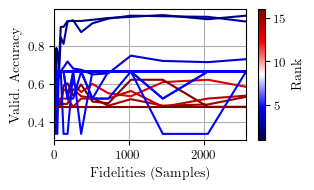

In [24]:
# Meaning of indexes
# fidelities, (train|valid|test), (accuracy|loss)

# Configuration of the plot
selected_split = "valid"
selected_score = "accuracy"

# Plotting
score_types = r_df["m:score_types"][0].tolist()
splits = ["train", "valid", "test"]
unit = r_df['m:fidelity_unit'][0]

idx_split = splits.index(selected_split)
idx_score = score_types.index(selected_score)

cmap = mpl.colormaps["seismic"]

fig = plt.figure()

# corresponds to iloc indexing
scores_max_fidelity = r_df["m:score_values"].map(lambda x: x[-1, idx_split, idx_score]).to_numpy()
ranking = rank(-scores_max_fidelity, decimals=3)
ranking_max = ranking.max()
for i in range(len(r_df)):
    fidelities = r_df.iloc[i]["m:fidelity_values"]
    scores = r_df.iloc[i]["m:score_values"][:, idx_split, idx_score]
    plt.plot(fidelities, scores, color=cmap(ranking[i]/ranking_max))

plt.xlabel(f"Fidelities ({unit.capitalize()})")
plt.ylabel(f"{selected_split.capitalize()}. {selected_score.capitalize()}")

plt.grid()

norm = mpl.cm.ScalarMappable(norm=None, cmap=cmap)
norm.set_clim(1, ranking_max)
cb = plt.colorbar(norm, ax=plt.gca(), label="Rank")
plt.xlim(0, fidelities.max())

plt.tight_layout()
plt.savefig(f"{unit}_{selected_split}-{selected_score}.png")
plt.show()